## Description

Here we demonstrate the prognostic value of NfL, 
those are clinical variable of interest
'mrs_30', 'mrs_90'

Figure 4


Number of subjects per day by outcome group:
mrs_90_bin      Good (0–3)  Poor (4–6)
days_after_lkn                        
0                       16          12
1                       17          14
3                       17          14
5                       12          11


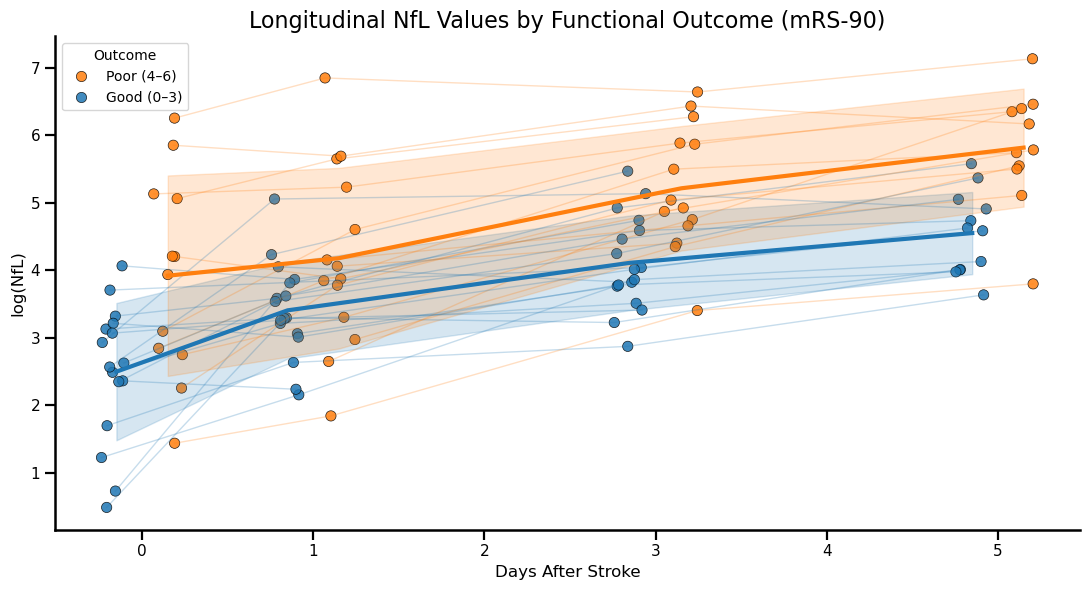

Spearman: 0.43451680210590427 1.5189787495525078e-06

=== Overall Correlations ===
Spearman rho = 0.413, p = 0.0000
Pearson r = 0.405, p = 0.0000

=== Day-wise Correlations (log_nfl vs mRS 90) ===
   day   n  Spearman_rho  Spearman_p  Pearson_r  Pearson_p
0    0  28      0.536961    0.003217   0.552776   0.002284
1    1  31      0.347158    0.055690   0.350426   0.053273
2    3  31      0.476230    0.006765   0.484757   0.005714
3    5  23      0.502181    0.014613   0.487308   0.018349

=== Day-wise Effect Size Summary ===
   day  n_good  n_poor     U     p_mwu   cohen_d  rank_biserial_r  \
0    0      16      12  45.0  0.019058 -1.149484         0.531250   
1    1      17      14  70.0  0.054208 -0.742048         0.411765   
2    3      17      14  42.0  0.002393 -1.367265         0.647059   
3    5      12      11  15.0  0.001883 -1.694271         0.772727   

   point_biserial_r  
0          0.508354  
1          0.356690  
2          0.575380  
3          0.663037  


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import spearmanr, pearsonr
import matplotlib as mpl
from scipy.stats import mannwhitneyu, ttest_ind, pointbiserialr
import numpy as np

imputed_nfl_df = pd.read_csv('nihss_nfl_cyto_mrs_wbc_mrs_imputedct.csv',index_col=0)

nfl_plot_data = (
    imputed_nfl_df[imputed_nfl_df['days_after_lkn'].isin([0,1,3,5])]
    .dropna(subset=['nfl'])
    .drop_duplicates(subset=['personid','days_after_lkn','nfl'])
    .copy()
)
nfl_plot_data['smoking_binary'] = nfl_plot_data['smoking'].map({0: 0, 1: 1, 2: 1})

nfl_plot_data['log_nfl'] = np.log(nfl_plot_data['nfl'])


mpl.rcParams["pdf.fonttype"] = 42   # TrueType fonts (editable)
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["svg.fonttype"] = "none"

nfl_plot_data['mrs_90_bin'] = nfl_plot_data['mrs_90'].apply(
    lambda x: "Good (0–3)" if x <= 3 else "Poor (4–6)"
)

palette = {
    "Good (0–3)": sns.color_palette("tab10")[0],
    "Poor (4–6)": sns.color_palette("tab10")[1],
}

jitter_width = 0.10   # small jitter for readability
group_offset = 0.15   # separation between groups

rng = np.random.default_rng(42)
nfl_plot_data_current = nfl_plot_data.copy()
nfl_plot_data_current = nfl_plot_data_current.dropna(subset=['mrs_90'])
# jitter
nfl_plot_data_current['x_jitter'] = rng.uniform(
    -jitter_width, jitter_width, size=len(nfl_plot_data_current)
)

# group offset
group_map = {
    "Good (0–3)": -group_offset,
    "Poor (4–6)": +group_offset
}

nfl_plot_data_current['x_plot'] = nfl_plot_data_current.apply(
    lambda row: row['days_after_lkn'] +
                row['x_jitter'] +
                group_map[row['mrs_90_bin']],
    axis=1
)

summary_counts = (
    nfl_plot_data_current.groupby(['days_after_lkn', 'mrs_90_bin'])['personid']
    .nunique()
    .reset_index()
    .pivot(index='days_after_lkn', columns='mrs_90_bin', values='personid')
)

print("\nNumber of subjects per day by outcome group:")
print(summary_counts.fillna(0))

summary_stats = nfl_plot_data_current.groupby(['days_after_lkn', 'mrs_90_bin']).agg(
    mean=('log_nfl', 'mean'),
    sd=('log_nfl',  'std')
).reset_index()

# add x-position offset for group separation (WITHOUT jitter)
summary_stats['x_mean'] = summary_stats.apply(
    lambda row: row['days_after_lkn'] + group_map[row['mrs_90_bin']],
    axis=1
)

plt.figure(figsize=(11, 6))

# A. Jittered raw points
sns.scatterplot(
    data=nfl_plot_data_current,
    x='x_plot', y='log_nfl',
    hue='mrs_90_bin',
    palette=palette,
    s=55,
    alpha=0.85,
    linewidth=0.5,
    edgecolor='black'
)

for (pid, group), dfsub in nfl_plot_data_current.groupby(['personid', 'mrs_90_bin']):
    plt.plot(
        dfsub['x_plot'],
        dfsub['log_nfl'],
        color=palette[group],
        alpha=0.25,
        linewidth=1
    )

for group, dfsub in summary_stats.groupby('mrs_90_bin'):
    col = palette[group]

    # mean line
    plt.plot(
        dfsub['x_mean'], dfsub['mean'],
        color=col,
        linewidth=3
    )

    # SD ribbon
    plt.fill_between(
        dfsub['x_mean'],
        dfsub['mean'] - dfsub['sd'],
        dfsub['mean'] + dfsub['sd'],
        color=col,
        alpha=0.18
    )

ax = plt.gca()

for spine in ["bottom", "left"]:
    ax.spines[spine].set_linewidth(1.8)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(
    axis="both",
    which="major",
    length=7,      # tick length
    width=1.6,     # tick thickness
    labelsize=11
)
plt.title("Longitudinal NfL Values by Functional Outcome (mRS-90)", fontsize=16)
plt.xlabel("Days After Stroke", fontsize=12)
plt.ylabel("log(NfL)", fontsize=12)

plt.legend(title="Outcome", frameon=True)
plt.tight_layout()
plt.show()


nfl_plot_data["mrs_90_bin_num"] = np.where(
    nfl_plot_data["mrs_90"].isna(),
    np.nan,
    (nfl_plot_data["mrs_90"] > 3).astype(int)
)


clean = nfl_plot_data[['log_nfl','mrs_90', 'mrs_90_bin', 'mrs_90_bin_num', 'days_after_lkn']].dropna(subset=["log_nfl", "mrs_90"])

rho, p_rho = spearmanr(clean['log_nfl'], clean['mrs_90_bin_num'])
r, p_r  = pearsonr(clean['log_nfl'], clean['mrs_90_bin_num'])

print("Spearman:", rho, p_rho)

rho_all, p_s_all = spearmanr(clean["log_nfl"], clean["mrs_90"])
r_all, p_p_all = pearsonr(clean["log_nfl"], clean["mrs_90"])

print("\n=== Overall Correlations ===")
print(f"Spearman rho = {rho_all:.3f}, p = {p_s_all:.4f}")
print(f"Pearson r = {r_all:.3f}, p = {p_p_all:.4f}")

daywise_corrs = []

for day, df_day in clean.groupby("days_after_lkn"):
    if df_day["mrs_90"].nunique() > 1:
        rho, p_s = spearmanr(df_day["log_nfl"], df_day["mrs_90"])
        r, p_p = pearsonr(df_day["log_nfl"], df_day["mrs_90"])
    else:  # cannot compute correlation if all mRS same
        rho, p_s, r, p_p = np.nan, np.nan, np.nan, np.nan

    daywise_corrs.append([day, len(df_day), rho, p_s, r, p_p])

daywise_corrs = pd.DataFrame(
    daywise_corrs,
    columns=["day", "n", "Spearman_rho", "Spearman_p", "Pearson_r", "Pearson_p"]
)

print("\n=== Day-wise Correlations (log_nfl vs mRS 90) ===")
print(daywise_corrs)



results = []

for day, df_day in nfl_plot_data.groupby("days_after_lkn"):

    df_day = df_day.dropna(subset=['log_nfl', 'mrs_90_bin_num'])
    g = df_day[df_day['mrs_90_bin_num'] == 0]['log_nfl']
    p = df_day[df_day['mrs_90_bin_num'] == 1]['log_nfl']

    # Skip day if any group has <2 subjects
    if len(g) < 2 or len(p) < 2:
        results.append([day, len(g), len(p),
                        np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
        continue
    U, p_mwu = mannwhitneyu(g, p, alternative="two-sided")


    n1, n2 = len(g), len(p)
    r_rb = 1 - (2 * U) / (n1 * n2)
    # t_stat, p_t = ttest_ind(g, p, equal_var=False)

    mean_diff = g.mean() - p.mean()
    pooled_sd = np.sqrt(((n1 - 1)*g.var() + (n2 - 1)*p.var()) / (n1 + n2 - 2))
    d = mean_diff / pooled_sd

    labels = df_day['mrs_90_bin_num']     # 0 good, 1 poor
    values = df_day['log_nfl']
    r_pb, p_pb = pointbiserialr(labels, values)
    results.append([
        day, n1, n2,
        U, p_mwu,
        d, r_rb, r_pb
    ])

# Final dataframe
results_df = pd.DataFrame(
    results,
    columns=[
        'day','n_good','n_poor',
        'U','p_mwu',
        'cohen_d','rank_biserial_r','point_biserial_r'
    ]
)

print("\n=== Day-wise Effect Size Summary ===")
print(results_df)

## 30-day mRS


Number of subjects per day by outcome group:
mrs_30_bin      Good (0–3)  Poor (4–6)
days_after_lkn                        
0                       13          16
1                       15          17
3                       15          17
5                       11          13


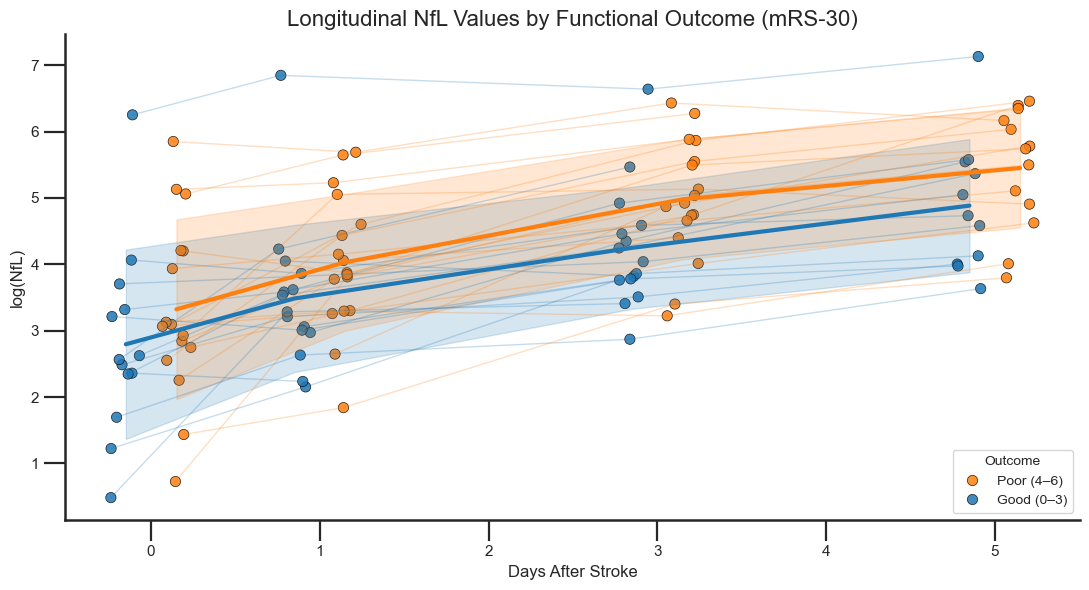

Spearman: 0.24518878461301302 0.007711492977476795

=== Overall Correlations ===
Spearman rho = 0.329, p = 0.0003
Pearson r = 0.318, p = 0.0005

=== Day-wise Correlations (log_nfl vs mRS 30) ===
   day   n  Spearman_rho  Spearman_p  Pearson_r  Pearson_p
0    0  29      0.358382    0.056260   0.380534   0.041706
1    1  32      0.440887    0.011547   0.379669   0.032092
2    3  32      0.456130    0.008695   0.452117   0.009380
3    5  24      0.381352    0.065960   0.352449   0.091188

=== Day-wise Effect Size Summary ===
   day  n_good  n_poor     U     p_mwu   cohen_d  rank_biserial_r  \
0    0      13      16  77.0  0.245194 -0.380295         0.259615   
1    1      15      17  74.0  0.045347 -0.511051         0.419608   
2    3      15      17  66.0  0.021249 -0.802767         0.482353   
3    5      11      13  43.0  0.104756 -0.598319         0.398601   

   point_biserial_r  
0          0.192347  
1          0.254703  
2          0.382307  
3          0.297297  


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import spearmanr, pearsonr
sns.set_style('ticks')
mpl.rcParams["pdf.fonttype"] = 42   # TrueType fonts (editable)
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["svg.fonttype"] = "none"

nfl_plot_data['mrs_30_bin'] = nfl_plot_data['mrs_30'].apply(
    lambda x: "Good (0–3)" if x <= 3 else "Poor (4–6)"
)

# consistent palette
palette = {
    "Good (0–3)": sns.color_palette("tab10")[0],
    "Poor (4–6)": sns.color_palette("tab10")[1],
}

jitter_width = 0.10   
group_offset = 0.15   # separation between groups

rng = np.random.default_rng(42)
nfl_plot_data_current = nfl_plot_data.copy()
nfl_plot_data_current = nfl_plot_data_current.dropna(subset=['mrs_30'])
# jitter
nfl_plot_data_current['x_jitter'] = rng.uniform(
    -jitter_width, jitter_width, size=len(nfl_plot_data_current)
)

# group offset
group_map = {
    "Good (0–3)": -group_offset,
    "Poor (4–6)": +group_offset
}

nfl_plot_data_current['x_plot'] = nfl_plot_data_current.apply(
    lambda row: row['days_after_lkn'] +
                row['x_jitter'] +
                group_map[row['mrs_30_bin']],
    axis=1
)


summary_counts = (
    nfl_plot_data_current.groupby(['days_after_lkn', 'mrs_30_bin'])['personid']
    .nunique()
    .reset_index()
    .pivot(index='days_after_lkn', columns='mrs_30_bin', values='personid')
)

print("\nNumber of subjects per day by outcome group:")
print(summary_counts.fillna(0))

summary_stats = nfl_plot_data_current.groupby(['days_after_lkn', 'mrs_30_bin']).agg(
    mean=('log_nfl', 'mean'),
    sd=('log_nfl',  'std')
).reset_index()

# add x-position offset for group separation (WITHOUT jitter)
summary_stats['x_mean'] = summary_stats.apply(
    lambda row: row['days_after_lkn'] + group_map[row['mrs_30_bin']],
    axis=1
)


plt.figure(figsize=(11, 6))

# A. Jittered raw points
sns.scatterplot(
    data=nfl_plot_data_current,
    x='x_plot', y='log_nfl',
    hue='mrs_30_bin',
    palette=palette,
    s=55,
    alpha=0.85,
    linewidth=0.5,
    edgecolor='black'
)

# B. Individual subject lines (perfect alignment)
for (pid, group), dfsub in nfl_plot_data_current.groupby(['personid', 'mrs_30_bin']):
    plt.plot(
        dfsub['x_plot'],
        dfsub['log_nfl'],
        color=palette[group],
        alpha=0.25,
        linewidth=1
    )

# C. Mean ± SD (plotted at true timepoints + group offset)
for group, dfsub in summary_stats.groupby('mrs_30_bin'):
    col = palette[group]

    # mean line
    plt.plot(
        dfsub['x_mean'], dfsub['mean'],
        color=col,
        linewidth=3
    )

    # SD ribbon
    plt.fill_between(
        dfsub['x_mean'],
        dfsub['mean'] - dfsub['sd'],
        dfsub['mean'] + dfsub['sd'],
        color=col,
        alpha=0.18
    )

# ----------------------------------------
# 6. Formatting
# ----------------------------------------
plt.title("Longitudinal NfL Values by Functional Outcome (mRS-30)", fontsize=16)
plt.xlabel("Days After Stroke", fontsize=12)
plt.ylabel("log(NfL)", fontsize=12)
ax = plt.gca()

# Thicken visible spines
for spine in ["bottom", "left"]:
    ax.spines[spine].set_linewidth(1.8)

# Optionally hide top/right spines (clean, journal style)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(
    axis="both",
    which="major",
    length=15,      # tick length
    width=1.6,     # tick thickness
    labelsize=11
)

# Legend formatting
plt.legend(title="Outcome", frameon=True)

plt.tight_layout()

plt.show()



nfl_plot_data["mrs_30_bin_num"] = np.where(
    nfl_plot_data["mrs_30"].isna(),
    np.nan,
    (nfl_plot_data["mrs_30"] > 3).astype(int)
)



clean = nfl_plot_data[['log_nfl','mrs_30', 'mrs_30_bin', 'mrs_30_bin_num', 'days_after_lkn']].dropna(subset=["log_nfl", "mrs_30"])

rho, p_rho = spearmanr(clean['log_nfl'], clean['mrs_30_bin_num'])
r, p_r  = pearsonr(clean['log_nfl'], clean['mrs_30_bin_num'])

print("Spearman:", rho, p_rho)

rho_all, p_s_all = spearmanr(clean["log_nfl"], clean["mrs_30"])
r_all, p_p_all = pearsonr(clean["log_nfl"], clean["mrs_30"])

print("\n=== Overall Correlations ===")
print(f"Spearman rho = {rho_all:.3f}, p = {p_s_all:.4f}")
print(f"Pearson r = {r_all:.3f}, p = {p_p_all:.4f}")

daywise_corrs = []

for day, df_day in clean.groupby("days_after_lkn"):
    if df_day["mrs_30"].nunique() > 1:
        rho, p_s = spearmanr(df_day["log_nfl"], df_day["mrs_30"])
        r, p_p = pearsonr(df_day["log_nfl"], df_day["mrs_30"])
    else:  # cannot compute correlation if all mRS same
        rho, p_s, r, p_p = np.nan, np.nan, np.nan, np.nan

    daywise_corrs.append([day, len(df_day), rho, p_s, r, p_p])

daywise_corrs = pd.DataFrame(
    daywise_corrs,
    columns=["day", "n", "Spearman_rho", "Spearman_p", "Pearson_r", "Pearson_p"]
)

print("\n=== Day-wise Correlations (log_nfl vs mRS 30) ===")
print(daywise_corrs)


results = []

for day, df_day in nfl_plot_data.groupby("days_after_lkn"):

    df_day = df_day.dropna(subset=['log_nfl', 'mrs_30_bin_num'])
    g = df_day[df_day['mrs_30_bin_num'] == 0]['log_nfl']
    p = df_day[df_day['mrs_30_bin_num'] == 1]['log_nfl']

    # Skip day if any group has <2 subjects
    if len(g) < 2 or len(p) < 2:
        results.append([day, len(g), len(p),
                        np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
        continue

    U, p_mwu = mannwhitneyu(g, p, alternative="two-sided")

    # Rank-biserial correlation
    n1, n2 = len(g), len(p)
    r_rb = 1 - (2 * U) / (n1 * n2)

    t_stat, p_t = ttest_ind(g, p, equal_var=False)

    mean_diff = g.mean() - p.mean()
    pooled_sd = np.sqrt(((n1 - 1)*g.var() + (n2 - 1)*p.var()) / (n1 + n2 - 2))
    d = mean_diff / pooled_sd

    labels = df_day['mrs_30_bin_num']     # 0 good, 1 poor
    values = df_day['log_nfl']
    r_pb, p_pb = pointbiserialr(labels, values)

    # ------------------------------------------------------
    # Store
    # ------------------------------------------------------
    results.append([
        day, n1, n2,
        U, p_mwu,
        d, r_rb, r_pb
    ])

# Final dataframe
results_df = pd.DataFrame(
    results,
    columns=[
        'day','n_good','n_poor',
        'U','p_mwu',
        'cohen_d','rank_biserial_r','point_biserial_r'
    ]
)

print("\n=== Day-wise Effect Size Summary ===")
print(results_df)

## Prediction performance

/var/folders/6r/pj2ql3m51fv8_ycglzy0hnh40000gn/T/ipykernel_68070/1342160252.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Outcome", frameon=True)


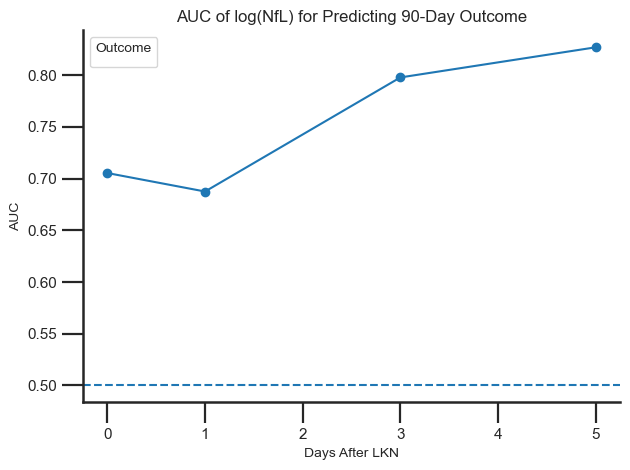

   day       AUC  p_value
0    0  0.705357   0.0240
1    1  0.687500   0.0355
2    3  0.797794   0.0020
3    5  0.826923   0.0000


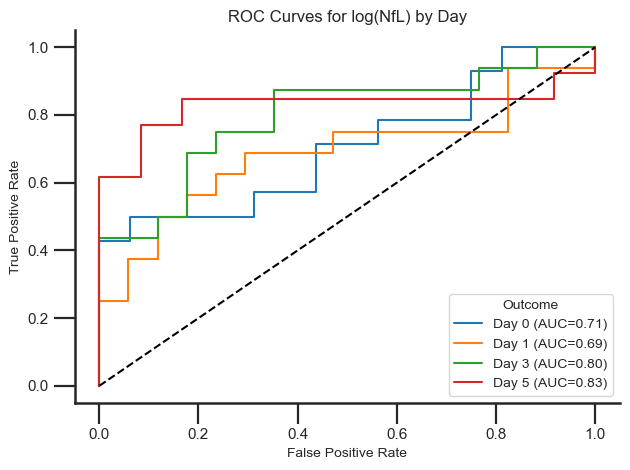

In [9]:
# prediction performance
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

auc_by_day = []
for day, df_day in nfl_plot_data.groupby("days_after_lkn"):
    y = df_day["mrs_90_bin"]
    x = df_day["log_nfl"]
    auc = roc_auc_score(y, x)
    auc_by_day.append([day, auc])

pd.DataFrame(auc_by_day, columns=["day","AUC"])
auc_df = pd.DataFrame(auc_by_day, columns=["day","AUC"]).sort_values("day")
plt.figure()
plt.plot(auc_df["day"], auc_df["AUC"], marker="o")
plt.xlabel("Days After LKN")
plt.ylabel("AUC")
plt.title("AUC of log(NfL) for Predicting 90-Day Outcome")
plt.axhline(0.5, linestyle="--")  # random baseline
ax = plt.gca()

for spine in ["bottom", "left"]:
    ax.spines[spine].set_linewidth(1.8)

# Optionally hide top/right spines (clean, journal style)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(
    axis="both",
    which="major",
    length=15,      # tick length
    width=1.6,     # tick thickness
    labelsize=11
)

plt.legend(title="Outcome", frameon=True)

plt.tight_layout()


plt.show()


def permutation_test_auc(x, y, n_perm=2000):
    real_auc = roc_auc_score(y, x)
    perm_aucs = np.zeros(n_perm)

    for i in range(n_perm):
        y_perm = np.random.permutation(y)
        perm_aucs[i] = roc_auc_score(y_perm, x)

    p_value = np.mean(perm_aucs >= real_auc)
    return real_auc, p_value
results = []

for day, df_day in nfl_plot_data.groupby("days_after_lkn"):
    auc, p = permutation_test_auc(df_day["log_nfl"], df_day["mrs_90_bin"])
    results.append([day, auc, p])

results_df = pd.DataFrame(results, columns=["day","AUC","p_value"])
print(results_df)
mapping = {"Good (0–3)": 0, "Poor (4–6)": 1}

for day, df_day in nfl_plot_data.groupby("days_after_lkn"):
    df_day["mrs_90_bin_int"] = df_day["mrs_90_bin"].map(mapping)

    y = df_day["mrs_90_bin_int"]
    x = df_day["log_nfl"]

    fpr, tpr, _ = roc_curve(y, x)
    auc_val = roc_auc_score(y, x)

    plt.plot(fpr, tpr, label=f"Day {day} (AUC={auc_val:.2f})")

plt.plot([0,1],[0,1], "k--")  # chance line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for log(NfL) by Day")
plt.legend()
ax = plt.gca()

# Thicken visible spines
for spine in ["bottom", "left"]:
    ax.spines[spine].set_linewidth(1.8)

# Optionally hide top/right spines (clean, journal style)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(
    axis="both",
    which="major",
    length=15,      # tick length
    width=1.6,     # tick thickness
    labelsize=11
)

# Legend formatting
plt.legend(title="Outcome", frameon=True)

plt.tight_layout()
plt.show()



## NIHSS
spearman p : P-values were computed using the asymptotic approximation of the Spearman rank correlation test statistic, assuming a t-distribution under the null hypothesis of zero association.

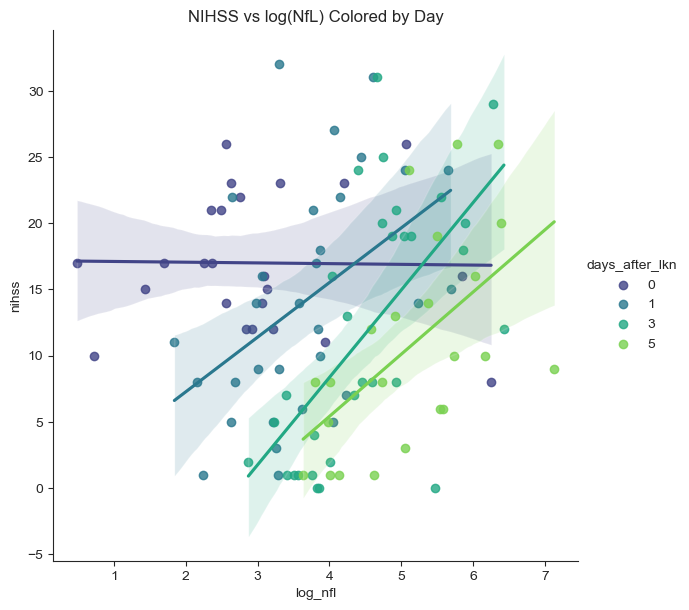

   day       rho         p
0    0 -0.080403  0.708798
1    1  0.501262  0.004071
2    3  0.628804  0.000152
3    5  0.635084  0.001131


In [10]:
from statsmodels.tsa.vector_ar.var_model import VAR


sns.lmplot(
    data=nfl_plot_data,
    x="log_nfl",
    y="nihss",
    hue="days_after_lkn",
    palette="viridis",
    height=6
)
plt.title("NIHSS vs log(NfL) Colored by Day")

plt.show()

nfl_plot_data_clean = nfl_plot_data[['log_nfl', 'nihss', 'days_after_lkn']].dropna()
rho, p = spearmanr(nfl_plot_data_clean['log_nfl'], nfl_plot_data_clean['nihss'])


day_corrs = []

for day, sub in nfl_plot_data_clean.groupby("days_after_lkn"):
    if len(sub) < 3:
        day_corrs.append([day, np.nan, np.nan])
        continue

    rho, p_s = spearmanr(sub["log_nfl"], sub["nihss"])
    day_corrs.append([day, rho, p_s])

day_corrs = pd.DataFrame(day_corrs, columns=["day","rho","p"])
print(day_corrs)



import statsmodels.formula.api as smf


df_lag = nfl_plot_data.sort_values(["personid","days_after_lkn"]).copy()

df_lag["log_nfl_lag1"] = df_lag.groupby("personid")["log_nfl"].shift(1)
df_lag["nihss_lag1"] = df_lag.groupby("personid")["nihss"].shift(1)

